In [7]:
# Data handling
import pandas as pd
import numpy as np
import datetime
import re
import math 
from GetFredData import *

# Statistics
from scipy import stats

# Modeling
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import cm
%matplotlib inline
sns.set_style("darkgrid")

# Misc
import itertools

In [199]:
class Utils():
    '''Dictionaries and functions for data manipulation
    '''
    fred_api_key = key = 'a250df75af2accf2846eacbb9ceaa4fd'
    state_abbrev = {
        'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY',
        'United States':'US'
        }
    
    def __init__(self):
        pass
    
class QTAX():
    '''Full qtax dataset
    
    Columns:
    period - indicates year and quarter in format (YYYY Q[1-4])
    original - non-seasonally adjusted value
    adjusted - seasonally adjusted value*
    state - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
    category - indicates type of tax. Types included are:
        - Property 
        - GeneralSalesandGross Receipts 
        - AlcoholicBeveragesSales 
        - AmusementsSales 
        - InsurancePremiumsSales 
        - MotorFuelsSales 
        - PariMutuelsSales 
        - PublicUtilitiesSales 
        - TobaccoProductsSales 
        - OtherSelectiveSalesandGrossReceipts 
        - AlcoholicBeveragesLicense
        - AmusementsLicense
        - CorporationsinGeneralLicense
        - HuntingandFishingLicense
        - MotorVehiclesLicense
        - MotorVehiclesOperatorsLicense
        - PublicUtilitiesLicense
        - OccupationandBusinessLicense
        - OtherLicense 
        - IndividualIncome 
        - CorporationNetIncome 
        - DeathandGift 
        - DocumentaryandStockTransfer 
        - Severance 
        - NEC (Other Not Elsewhere Classified)
        - Total 
        See dataset documentation for detail on category definitions.
    
    *seasonally adjusted values obtained with X-13 SEATS procedure run with RJDMetra package in R. Used 
    JDMetra 'RSA2c' preset specs: auto multiplicative/additive model detection; auto additive/level shift/temporary outlier detection;
    trading day and Easter calendar effects (thinking was that they would affect sales/stock transfer/and possibly license taxes);
    and the (0,1,1)(0,1,1) ARIMA model. 
    
    Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
    with their corresponding English language values for ease of reference) in Excel. New data will need to be edited in the same way
    to be compatible with this code.
    '''  
    def __init__(self, file_path = 'Data/QTAX_aug.csv'):
        self.data = pd.read_csv(file_path, header = 0, parse_dates = [0])
        self.data.set_index(['state','category'],inplace = True)
        
class UnemploymentRate():
    '''Container for unemployment rate data from FRED
    '''
    def __init__(self, state, data_start):
        ''' 
        state is two letter postal abbreviation
        data_start is passed to FRED API as beginning of desired unemployment data date range.
        '''
        self.unemp_data = pd.DataFrame()
        self.unemp_data['period'] = pd.date_range(start = data_start, end = '2020-04-01', freq = 'QS')
        self.unemp_data['ur'] = Series(Utils.fred_api_key,'{}UR'
                                       .format(state)).get_data(frequency = 'q', 
                                        observation_start = data_start, observation_end = '2020-04-01').data['value'].astype('float64')
        self.unemp_data.set_index('period',inplace = True)
        self.unemp_data = self.unemp_data.apply(lambda x: x.pct_change(periods = 2))
        self.unemp_data.dropna(inplace = True)
        
class State():
    '''Container for state specific tax and unemployment data.
    '''
    def __init__(self, name, data_start):
        self.name = name
        self.abbrev = Utils.state_abbrev[self.name]
        self.tax_data = QTAX().data.loc[self.abbrev]
        self.unemp_data = UnemploymentRate(self.abbrev, data_start).unemp_data
        
    def __str__(self):
        return self.name
    
class Model1():
    '''Naive model just using average non-recession growth rate over period to estimate revenue'''
    
    def __init__(self, state, tax_category):
        self.state = state
        self.category = tax_category
        
        self.data = self.state.tax_data.loc[self.category][['period','adjusted','2q_gr']]
        self.data.set_index('period', inplace = True)
        self.data['adjusted_lag2'] = self.data['adjusted'].shift(2)
        recession = pd.concat([self.data.loc['2000-04-01':'2003-10-01'],self.data.loc['2007-01-01':'2011-07-01']])
        non_recession = pd.concat([self.data.loc[:'2000-01-01'],self.data.loc['2004-01-01':'2006-10-01'],self.data.loc['2011-10-01':]]) 
        recession['recession'] = True
        non_recession['recession'] = False
        self.data = pd.concat([recession,non_recession]).sort_index()
        self.data = self.data.dropna()
        
        self.trend = self.data[self.data.recession == False]['2q_gr'].mean()
        
    def simulate(self):
        data = self.data
        data['preds'] = self.trend + 1
        data['preds'] = data['preds'].multiply(data['adjusted_lag2'])
        return data['preds']
    
    def plot(self):
        preds = self.simulate()
        fig, ax = plt.subplots()
        ax.plot(preds, label = 'Predicted')
        ax.plot(self.data['adjusted'], label = 'Actual')
        ax.legend()
        fig.suptitle('{} {} Model 1 Predicted and Actual Revenue (Millions of Dollars)'.format(self.state.name, self.category))
        

class Model2():
    '''Model non-recession tax growth rate as average over non-recession period. Model recession tax growth
    rate as function of lag-0, lag-1, and lag-3 unemployment growth rates, and lag-1 tax growth rate.
    '''
    
    def __init__(self, state, tax_category):
        '''state is a State object
        '''
        self.state = state
        self.category = tax_category
        
        self.data = self.state.tax_data.loc[self.category][['period','adjusted','2q_gr']]
        self.data.set_index('period', inplace = True)
        self.data = self.data.merge(self.state.unemp_data, left_index = True, right_index = True)
        self.data['adjusted_lag2'] = self.data['adjusted'].shift(2)
        self.data['2q_gr_lag1'] = self.data['2q_gr'].shift(1)
        self.data['ur_lag1'] = self.data['ur'].shift(1)
        self.data['ur_lag3'] = self.data['ur'].shift(3)    
        recession = pd.concat([self.data.loc['2000-04-01':'2003-10-01'],self.data.loc['2007-01-01':'2011-07-01']])
        non_recession = pd.concat([self.data.loc[:'2000-01-01'],self.data.loc['2004-01-01':'2006-10-01'],self.data.loc['2011-10-01':]]) 
        recession['recession'] = True
        non_recession['recession'] = False
        self.data = pd.concat([recession,non_recession]).sort_index()
        self.data = self.data.dropna()
        
        self.trend = self.data[self.data.recession == False]['2q_gr'].mean()
        
        self.fit(1000)
        
    def fit(self, bootstrap_n):
        sample = resample(self.data, replace=True, n_samples=bootstrap_n, random_state=1)
        X = sample[sample.recession == True][['2q_gr_lag1','ur','ur_lag1','ur_lag3']]
        y = sample[sample.recession == True]['2q_gr']
        self.model = linear_model.LinearRegression().fit(X,y)
    
    def simulate(self):
        data = self.data
        data['preds'] = np.where(data['recession'] == True, self.model.predict(data[['2q_gr_lag1','ur','ur_lag1','ur_lag3']]), self.trend)
        data['preds'] = data['preds'].apply(lambda x: x + 1)
        data['preds'] = data['preds'].multiply(data['adjusted_lag2'])
        return data['preds']
    
    def plot(self):
        preds = self.simulate()
        fig, ax = plt.subplots()
        ax.plot(preds, label = 'Predicted')
        ax.plot(self.data['adjusted'], label = 'Actual')
        ax.legend()
        fig.suptitle('{} {} Predicted and Actual Revenue (Millions of Dollars)'.format(self.state.name, self.category))
        

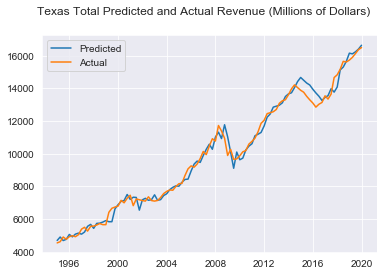

In [196]:
# Texas
tx = State('Texas', data_start = '1993-01-01')
tx_total_model = Model2(tx, 'Total')
tx_total_model.plot()

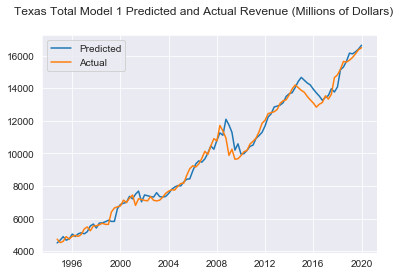

In [200]:
tx_total_model = Model1(tx, 'Total')
tx_total_model.plot()

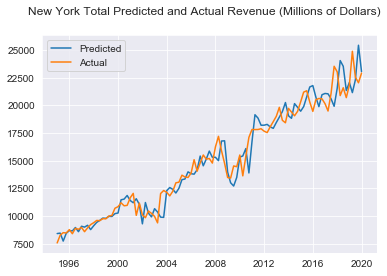

In [190]:
ny = State('New York', data_start = '1993-01-01')
ny_total_model = Model2(ny, 'Total')
ny_total_model.plot()

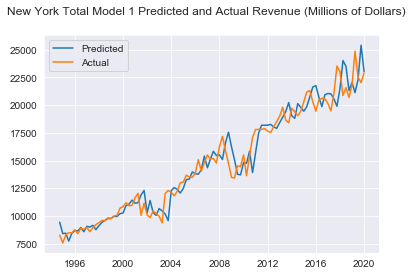

In [201]:
ny = State('New York', data_start = '1993-01-01')
ny_total_model = Model1(ny, 'Total')
ny_total_model.plot()

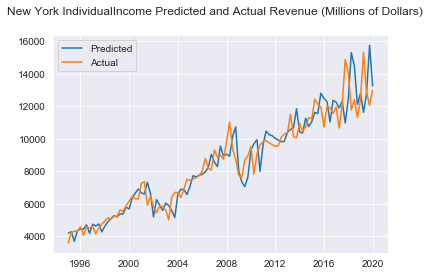

In [191]:
ny = State('New York', data_start = '1993-01-01')
ny_total_model = Model2(ny, 'IndividualIncome')
ny_total_model.plot()

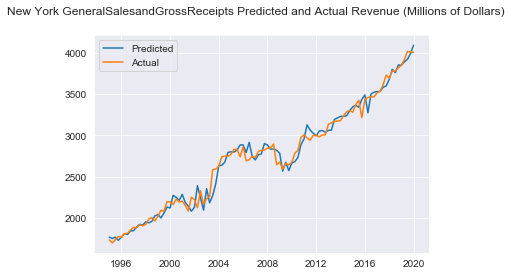

In [192]:
ny = State('New York', data_start = '1993-01-01')
ny_total_model = Model2(ny, 'GeneralSalesandGrossReceipts')
ny_total_model.plot()

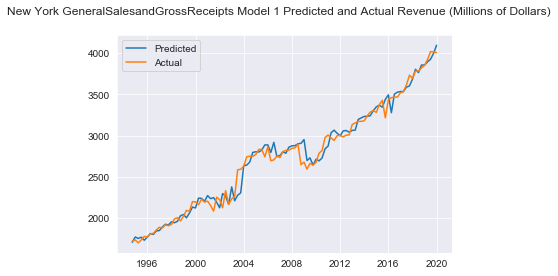

In [202]:
ny_total_model = Model1(ny, 'GeneralSalesandGrossReceipts')
ny_total_model.plot()

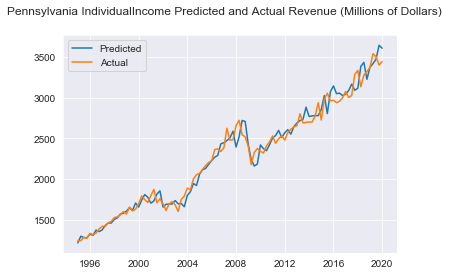

In [203]:
pa = State('Pennsylvania', data_start = '1993-01-01')
pa_total_model = Model2(pa, 'IndividualIncome')
pa_total_model.plot()

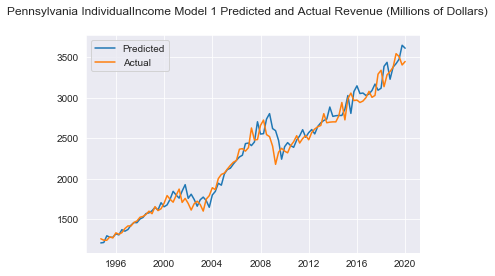

In [205]:
pa = State('Pennsylvania', data_start = '1993-01-01')
pa_total_model = Model1(pa, 'IndividualIncome')
pa_total_model.plot()

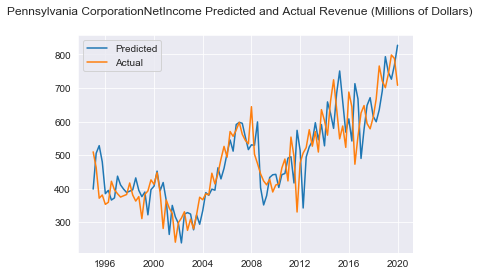

In [207]:
pa = State('Pennsylvania', data_start = '1993-01-01')
pa_total_model = Model2(pa, 'CorporationNetIncome')
pa_total_model.plot()

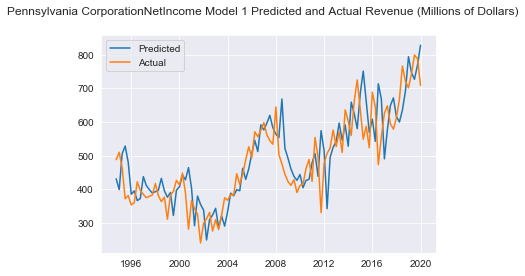

In [208]:
pa = State('Pennsylvania', data_start = '1993-01-01')
pa_total_model = Model1(pa, 'CorporationNetIncome')
pa_total_model.plot()

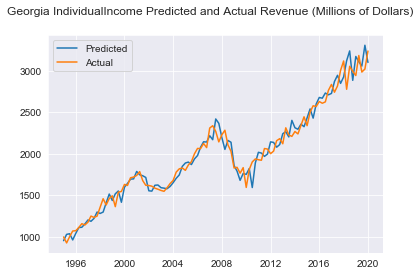

In [212]:
ga = State('Georgia', data_start = '1993-01-01')
ga_total_model = Model2(ga, 'IndividualIncome')
ga_total_model.plot()

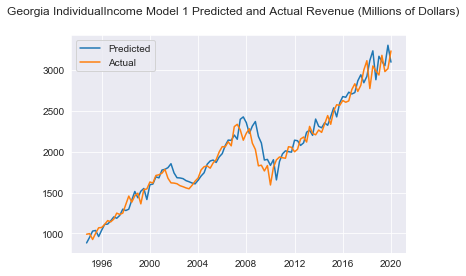

In [211]:
ga = State('Georgia', data_start = '1993-01-01')
ga_total_model = Model1(ga, 'IndividualIncome')
ga_total_model.plot()